# Imports

In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from mitsuba.scalar_rgb import Transform4f as T
from matplotlib import pyplot as plt

# Settings

In [2]:
mi.set_variant("llvm_ad_rgb")

In [3]:
spp = 32
seed = 0

In [4]:
key = 'sensor.principal_point_offset_x'

In [5]:
samples_x = dr.linspace(dr.auto.ad.Float, 0, 1, 100)
samples_y = dr.linspace(dr.auto.ad.Float, 0, 1, 100)

# Custom Camera

In [6]:
class CustomCamera(mi.Sensor):
    def __init__(self, props):
        super().__init__(props)

        self.m_to_world = props.get('to_world')
        self.m_film = props.get('film')
        size = self.m_film.size()
        self.m_x_fov = mi.parse_fov(props, size.x / size.y)
        self.m_near_clip = props.get("near_clip", 0.1)
        self.m_far_clip = props.get("far_clip", 1000.0)
        self.m_focus_distance = props.get("focus_distance")
        self.m_resolution = mi.ScalarVector2f(self.m_film.crop_size())

        self.m_principal_point_offset_x = mi.Float(props.get('principal_point_offset_x'))

        self.update_camera_transform()


    def update_camera_transform(self):
        self.m_camera_to_sample = mi.perspective_projection(mi.ScalarVector2i(self.m_film.size()), mi.ScalarVector2i(self.m_film.crop_size()), mi.ScalarVector2i(self.m_film.crop_offset()), mi.Float(self.m_x_fov), mi.Float(self.m_near_clip), mi.Float(self.m_far_clip))
        self.m_sample_to_camera = self.m_camera_to_sample.inverse()


    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        [wavelengths, wav_weight] = self.sample_wavelengths(dr.zeros(mi.SurfaceInteraction3f), sample1, active);
        ray = mi.RayDifferential3f()
        ray.time = time
        ray.wavelengths = wavelengths

        scaled_principal_point_offset_x = self.m_film.size().x * self.m_principal_point_offset_x / self.m_film.crop_size().x;

        near_p = self.m_sample_to_camera @ mi.Point3f(sample2.x + scaled_principal_point_offset_x, sample2.y, dr.auto.ad.Float(0.0))

        d = dr.normalize(mi.Vector3f(near_p))

        ray.o = self.m_to_world.translation()

        M = self.m_to_world.matrix

        M3x3 = mi.Matrix3f(
            [M[0][0], M[0][1], M[0][2]],
            [M[1][0], M[1][1], M[1][2]],
            [M[2][0], M[2][1], M[2][2]]
        )
        ray.d = M3x3 @ d

        inv_z  = dr.rcp(d.z)
        near_t = self.m_near_clip * inv_z
        far_t = self.m_far_clip * inv_z
        ray.o += ray.d * near_t
        ray.maxt = far_t - near_t

        ray.o_x = ray.o_y = ray.o

        ray.d_x = mi.Vector3f(0.0,0.0,0.0) # Has no influence in the example.
        ray.d_y = mi.Vector3f(0.0,0.0,0.0) # Has no influence in the example.
        ray.has_differentials = True

        return ray, wav_weight


    def traverse(self, callback):
        callback.put_parameter("principal_point_offset_x", self.m_principal_point_offset_x, mi.ParamFlags.Differentiable)


    def to_string(self):
        return f"Custom Camera"


In [7]:
mi.register_sensor("custom_camera", lambda props: CustomCamera(props))

# Scene

In [8]:
integrator = {
    'type': 'path',
    'max_depth': 6
}

camera_sensor = {
        'type': 'custom_camera',
        'fov_axis': 'smaller',
        'near_clip': 0.001,
        'far_clip': 100.0,
        'focus_distance': 1000.0,
        'fov': 60.0,
        'principal_point_offset_x': 0.0,
        'to_world': T().look_at(
                        origin=(0, 0, 3.0),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'sampler': {
            'type': 'independent',
            'sample_count': 128
        },
        'film': {
            'type': 'hdrfilm',
            'width': 128,
            'height': 128,
            'rfilter': { 'type': 'tent' },
            'pixel_format': 'rgb',
            'component_format': 'float32'
        }
    }

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor': camera_sensor,

'gray': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.85, 0.85, 0.85) }
},
'white': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.885809, 0.698859, 0.666422) }
},
'green': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.105421, 0.37798, 0.076425) }
},
'red': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.570068, 0.0430135, 0.0443706) }
},

'light': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_luminaire.obj',
    'to_world': T().translate([0, -0.01, 0]),
    'bsdf': { 'type': 'ref', 'id': 'white' },
    'emitter': {
        'type': 'area',
        'radiance': { 'type': 'rgb', 'value': (18.387, 13.9873, 6.75357) }
    }
},

'floor': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_floor.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'ceiling': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_ceiling.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'back': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_back.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'greenwall': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_greenwall.obj',
    'bsdf': { 'type': 'ref', 'id': 'green' },
},
'redwall': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_redwall.obj',
    'bsdf': { 'type': 'ref', 'id': 'red' }
},

'bunny': {
    'type': 'ply',
    'filename': 'scenes/meshes/bunny.ply',
    'to_world': T().scale(6),
    'bsdf': {
        'type': 'diffuse',
        'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) }
    }
},
})

params = mi.traverse(scene)

In [9]:
camera = mi.load_dict(camera_sensor)

# Reference

In [10]:
reference = camera.sample_ray_differential(mi.Float(0.0), mi.Float(0.0), mi.Point2f(samples_x,samples_y), mi.Point2f(0.0, 0.0))
reference_directions = reference[0].d

image_ref = mi.render(scene, spp=spp, seed=seed)
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# Initialization

In [11]:
camera.m_principal_point_offset_x = 0.2

initial = camera.sample_ray_differential(mi.Float(0.0), mi.Float(0.0), mi.Point2f(samples_x,samples_y), mi.Point2f(0.0, 0.0))

initial_directions = initial[0].d
params['sensor.principal_point_offset_x'] = camera.m_principal_point_offset_x
params.update()

image_init = mi.render(scene, spp=spp, seed=seed)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# AD Optimizatin

In [12]:
opt = mi.ad.Adam(lr=0.01)
opt['principal_point_offset_x'] = dr.auto.ad.Float(camera.m_principal_point_offset_x)

In [13]:
iterations = 100
loss_hist = []
ad_grads = []
fd_grads = []

params.update(opt)

for it in range(iterations):
    original_param = opt['principal_point_offset_x']

    # ---------- AD ----------
    camera.m_principal_point_offset_x = opt['principal_point_offset_x']
    
    values = camera.sample_ray_differential(mi.Float(0.0), mi.Float(0.0), mi.Point2f(samples_x,samples_y), mi.Point2f(0.0, 0.0))[0].d

    loss = dr.sum(dr.sum(dr.square(values - reference_directions ))/len(reference_directions.array))
    loss_hist.append(loss.array[0])
    dr.backward(loss)
    ad_grad = dr.grad(camera.m_principal_point_offset_x)
    ad_grads.append(ad_grad[0])
    opt.step()
    # ------------------------


    # ---------- FD ----------
    with dr.suspend_grad():
        epsilon = 1e-4
        camera.m_principal_point_offset_x = original_param + epsilon
        values_plus = camera.sample_ray_differential(mi.Float(0.0), mi.Float(0.0), mi.Point2f(samples_x,samples_y), mi.Point2f(0.0, 0.0))[0].d
        loss_plus = dr.sum(dr.sum(dr.square(values_plus - reference_directions ))/len(reference_directions.array))

        camera.m_principal_point_offset_x = original_param - epsilon
        values_minus = camera.sample_ray_differential(mi.Float(0.0), mi.Float(0.0), mi.Point2f(samples_x,samples_y), mi.Point2f(0.0, 0.0))[0].d
        loss_minus = dr.sum(dr.sum(dr.square(values_minus - reference_directions ))/len(reference_directions.array))

        fd_grad = (loss_plus - loss_minus) / (2 * epsilon)
        fd_grads.append(fd_grad)

    # ------------------------


    params.update(opt)

    print(f"Iteration {it:02d}: loss = {loss}, grad_diff = {ad_grad[0] - fd_grad}", end='\r')

    

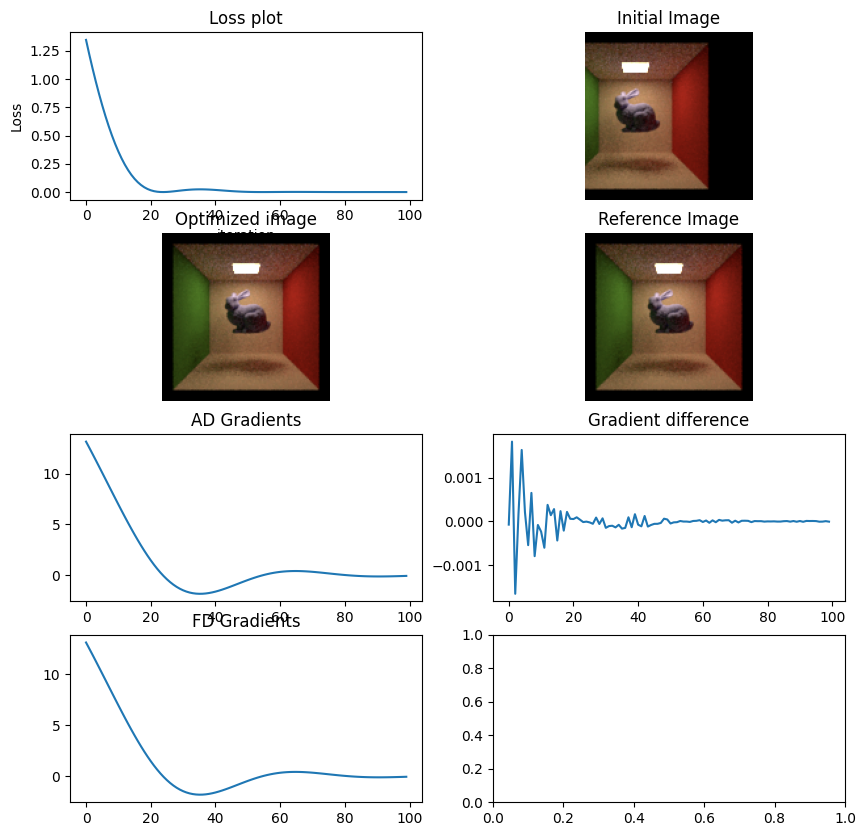

In [14]:
params['sensor.principal_point_offset_x'] = camera.m_principal_point_offset_x
params.update()

fig, axs = plt.subplots(4, 2, figsize=(10, 10))

loss_hist_np = [np.array(x) for x in loss_hist]

ad_grads_np = []
fd_grads_np = []
grad_difference = []
for i in range(len(ad_grads)):
    ad_grad_np = np.array(ad_grads[i])
    fd_grad_np = np.array(fd_grads[i])
    ad_grads_np.append(ad_grad_np)
    fd_grads_np.append(fd_grad_np)
    grad_difference.append(ad_grad_np-fd_grad_np)

axs[0][0].plot(loss_hist_np)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Loss plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(image_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=spp, seed=seed)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

axs[2][0].plot(ad_grads_np)
axs[2][0].set_title('AD Gradients');

axs[2][1].plot(grad_difference)
axs[2][1].set_title('Gradient difference');

axs[3][0].plot(fd_grads_np)
axs[3][0].set_title('FD Gradients');